<a href="https://colab.research.google.com/github/Koftarik/Data_Processing_and_Machine_Learning_Advanced/blob/main/Gorbuntsov_test_IMSh_Applied_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Горбунцов Александр
aagorbuntsov@edu.hse.ru

Ссылка на этот ноутбук в google colab: https://colab.research.google.com/drive/1jTcmuzdoQL7ZVKYWEL2fAs6JRGvPwE6Z#scrollTo=nCq40ofcJDpg

В .csv файле представлена совокупность данных: заголовок новости, тема новости, текст новости. Все слова в тексте лемматизированы, а сами тексты очищены от стоп-слов.

Вам необходимо выбрать и сравнить между собой не менее трех различных алгоритмов классификации текстов, проанализировать полученные результаты и сделать обоснованные выводы о применимости выбранных методов и качестве решения задачи.

Я планирую протестировать следующие алгоритмы:

1. Логистическая регрессия: Этот алгоритм использует логистическую функцию для оценки вероятностей принадлежности к классам. Он особенно полезен в задачах с двумя классами, но может быть применен и к многоклассовой классификации.

2. Support Vector Machines (SVM): SVM стремится разделить данные в пространстве высокой размерности с помощью разделяющей гиперплоскости. Он может быть эффективным для текстовой классификации, особенно когда данные являются линейно разделимыми.

3. Naive Bayes: Этот алгоритм основан на теореме Байеса и предполагает независимость признаков. Он хорошо работает с небольшими объемами данных и может быть эффективным для простых текстовых классификаций.

4. BERT: Это предтренированная модель на основе трансформеров, которая может быть эффективной для задач классификации текстов. Буду использовать модель rubert-tiny2, обученную на русский язык, она является относительно небольшой но вполне подходящей под задачу.


In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data = 'drive/MyDrive/Colab_Notebooks/data/articles_lemmatized_no_SW.csv'

Mounted at /content/drive


In [3]:
df = pd.read_csv(data)

**Разведка данных.**

Для начала я хочу узнать с чем вообще имею дело.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56500 entries, 0 to 56499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  56500 non-null  int64 
 1   headline    56500 non-null  object
 2   body        56499 non-null  object
 3   topic       56500 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [5]:
df.head(10)

,Unnamed: 0,headline,body,topic
0,4069,Теперь подарки можно выбрать на сайте при помо...,поиск подарок любой праздник гораздо просто бл...,IT
1,1666,Тренды розничной торговли 2016,платформа соцсеть продолжать служить шопинг-пл...,IT
2,1802,Порталы сравнения цен вынуждают мелких ритейле...,последний время активно расти конкуренция обла...,IT
3,3784,9 беспроигрышных подарков для мужчины,каждый накануне февраль возникать сложный вопр...,IT
4,2186,Китайские производители сокращают свой бизнес ...,прекращать поставка новый автомобиль дилер рос...,Авто
5,6624,Глава Подмосковья дал старт строительству ново...,дорожный сооружение появляться пересечение вол...,Авто
6,6625,В Крыму продолжается переход на российские гос...,легально передвигаться полуостров украинский н...,Авто
7,38807,Страховые компании назвали марки самых угоняем...,опасаться злоумышленник следовать владелец дор...,Авто
8,9418,На 14-м Пекинском международном автосалоне пре...,большой интерес публика привлекать китайский и...,Авто
9,9352,Названы лучшие автомобили года в России,москва состояться церемония вручение ежегодный...,Авто


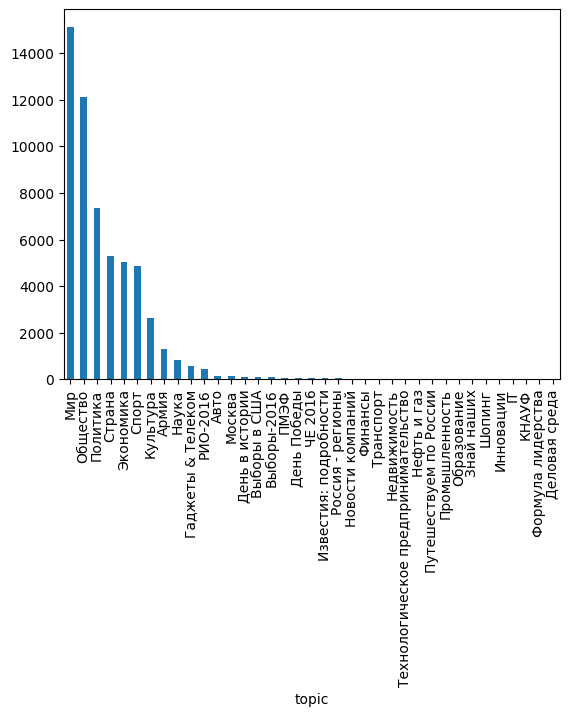

In [6]:
text_summary = df.groupby('topic').count().drop('headline', axis=1)
text_summary = text_summary.sort_values(by='body', ascending=False) # Сортируем данные по убыванию.
ax = text_summary.plot.bar(y='body') # Рисуем частоты.
ax.get_legend().remove() # Удаляем легенду.

Выборка несбалансирована, первые 7 классов абсолютно доминируют над оставшимися 30, более того, первые 2 класса по количеству элементов сравнимы с остальными 35.

В дальнейшем буду в основном смотреть на эффективность классификации по 7 основным классам: Мир, Общество, Политика, Страна, Экономика, Спорт, Культура.

In [25]:
print(text_summary)

                                     Unnamed: 0   body
topic                                                 
Мир                                       15131  15131
Общество                                  12147  12147
Политика                                   7359   7359
Страна                                     5280   5280
Экономика                                  5032   5032
Спорт                                      4881   4881
Культура                                   2635   2635
Армия                                      1295   1295
Наука                                       824    824
Гаджеты & Телеком                           583    583
РИО-2016                                    449    449
Авто                                        131    130
Москва                                      118    118
День в истории                              108    108
Выборы в США                                 96     96
Выборы-2016                                  92     92
ПМЭФ      

Неожиданно нахожу пропуск в данных.

In [7]:
df_empty_body = df[df['body'].isnull()]

# Выводим элементы DataFrame с пустым столбцом 'body'
print(df_empty_body)

     Unnamed: 0                      headline body topic
107        3926  Приключения LADA XRAY в Сочи  NaN  Авто


In [8]:
df['body'].fillna('', inplace=True)

In [9]:
df_empty_body = df[df['body'].isnull()]

# Выводим элементы DataFrame с пустым столбцом 'body'
print(df_empty_body)

Empty DataFrame
Columns: [Unnamed: 0, headline, body, topic]
Index: []


In [27]:
df_empty_topic = df[df['topic'].isnull()]
print(df_empty_topic)

Empty DataFrame
Columns: [Unnamed: 0, headline, body, topic]
Index: []


In [10]:
print (df['topic'].nunique())
unique_topics = df['topic'].unique()
# Подсчитываем максимальное количество символов в body
print (max(len(body) for body in df['body']))

37
48095


Делю данные на тренировочные и тестовые.

In [11]:
X = df['body']
y = df['topic']

In [12]:
X.shape, y.shape

((56500,), (56500,))

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39550,), (16950,), (39550,), (16950,))

Начнем с самого простого и очевидного алгоритма - логистической регрессии с Bag of Words.

**Логистическая регрессия.**

Основными преимуществами являются:

 - Простота реализации
 - Малое использование вычислительных мощностей
 - Не требуется настройка параметров

Недостатками являются:
 - Результаты предсказываются на основе набора независимых переменных
 - Не подходит для нелинейных задач

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import *
from nltk import ngrams

In [16]:
vec = CountVectorizer(ngram_range=(1, 1)) # строим BoW для слов
bow = vec.fit_transform(X_train)

In [30]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [18]:
pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                     precision    recall  f1-score   support

                                 IT       0.00      0.00      0.00         0
                               Авто       0.39      0.62      0.48        26
                              Армия       0.65      0.72      0.68       374
                       Выборы в США       0.17      0.42      0.24        12
                        Выборы-2016       0.14      0.31      0.19        13
                  Гаджеты & Телеком       0.58      0.64      0.61       155
                        День Победы       0.27      0.55      0.36        11
                     День в истории       0.30      0.50      0.38        20
              Известия: подробности       0.00      0.00      0.00         4
                          Инновации       0.00      0.00      0.00         0
                              КНАУФ       0.00      0.00      0.00         0
                           Культура       0.83      0.88      0.85       79

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

**SVM.**

Затем я рассмотрю метод SVM - машина опорных векторов с TF-IDF.

Преимущества данного алгоритма:

 - Эффективность с точки зрения памяти, так как использует подмножество обучающих точек для принятия решения
 - Хорошо справляется с задачами классификации в пространствах высокой размерности, что делает его особенно полезным для задач обработки текстов, где количество признаков может быть очень большим.
 -Способность работать с нелинейными разделяющими поверхностями: SVM может использовать ядерные функции для преобразования данных и преобразования их в нелинейные разделяющие поверхности. Это позволяет обрабатывать сложные данные, которые не могут быть линейно разделены.

Недостатки:
 - Результаты могут быть сложными для интерпретации, особенно когда используются ядерные функции. Он создает абстрактные разделяющие поверхности, которые могут быть сложными для понимания и объяснения.
 - При работе с большими объемами данных SVM может столкнуться с проблемой масштабирования. Обучение SVM может стать очень медленным и затратным на больших датасетах.


In [19]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [20]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC()),
                     ])
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC())])

In [21]:
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                     precision    recall  f1-score   support

                                 IT       0.00      0.00      0.00         2
                               Авто       0.77      0.56      0.65        41
                              Армия       0.73      0.66      0.69       415
                       Выборы в США       0.33      0.07      0.11        30
                        Выборы-2016       0.00      0.00      0.00        29
                  Гаджеты & Телеком       0.69      0.64      0.66       171
                        День Победы       0.55      0.27      0.36        22
                     День в истории       0.88      0.21      0.34        33
              Известия: подробности       0.33      0.29      0.31         7
                          Инновации       0.00      0.00      0.00         3
                              КНАУФ       0.00      0.00      0.00         1
                           Культура       0.87      0.88      0.87       84

**Naive Bayes.**

Наивный Байесовский классификатор.

Достоинства:
 - Простой и легко интерпретируемый алгоритм, который основан на принципе наивного предположения о независимости признаков. Это делает его легким в понимании и реализации.
 - Может обобщаться на новые данные, поскольку основан на вероятностной модели. Он может работать достаточно хорошо на незнакомых примерах.
 - Может эффективно работать с малыми объемами данных и иметь хорошую производительность. Он не требует большого количества размеченных данных для обучения.


Слабые стороны:
 - Ппредставляет текстовую информацию в виде мешка слов, не учитывая порядок слов или контекст. Это может привести к потере некоторой семантической информации, особенно если важен порядок слов.
 - Может иметь проблемы с редкими признаками, так как предполагает, что каждый признак встречается в каждом классе. Если редкие признаки не представлены в обучающих данных, модель может упустить их важность.

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [23]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [24]:
predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                     precision    recall  f1-score   support

                                 IT       0.00      0.00      0.00         2
                               Авто       0.00      0.00      0.00        41
                              Армия       1.00      0.00      0.00       415
                       Выборы в США       0.00      0.00      0.00        30
                        Выборы-2016       0.00      0.00      0.00        29
                  Гаджеты & Телеком       0.00      0.00      0.00       171
                        День Победы       0.00      0.00      0.00        22
                     День в истории       0.00      0.00      0.00        33
              Известия: подробности       0.00      0.00      0.00         7
                          Инновации       0.00      0.00      0.00         3
                              КНАУФ       0.00      0.00      0.00         1
                           Культура       0.93      0.47      0.63       84

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**BERT.**

Используем трансформер BERT

Плюсы данного метода:
 - Учитывает контекст и зависимости между словами при предсказывании, что позволяет ему понять семантическую связь между словами в предложении.
 - Может быть дообучен на различных задачах классификации, и его представления могут быть использованы для различных языков и типов данных.
 - Показывает высокую производительность во многих классификационных задачах, особенно на больших и сложных датасетах. Его способность учитывать контекст и семантику позволяет ему лучше идентифицировать семантическую связь между словами и принимать более точные решения о классификации.

Минусы:
 - Необходима чрезвычайная вычислительная мощность. На CPU обучение составляет более двух часов, для адекватной работы необходим GPU. Также модель имеет склонность переполнять ОЗУ, приходится делать батчи минимального размера, а также обрезать тексты.
 - Предтренировка BERT требует большого объема данных, и дообучение на конкретной задаче может потребовать большого времени и ресурсов. Это может быть большой проблемой, особенно если имеется ограниченное количество размеченных данных.

In [ ]:
! pip install -U transformers

In [26]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [27]:
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=37)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
X = df['body'].values
y = df['topic'].values
labels = np.unique(y)

In [30]:
encoded_inputs_train = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=96)
encoded_inputs_test = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=96)

In [31]:
input_ids_train = torch.tensor(encoded_inputs_train['input_ids'])
attention_mask_train = torch.tensor(encoded_inputs_train['attention_mask'])
input_ids_test = torch.tensor(encoded_inputs_test['input_ids'])
attention_mask_test = torch.tensor(encoded_inputs_test['attention_mask'])
labels_train = torch.tensor([labels.tolist().index(label) for label in y_train])
labels_test = torch.tensor([labels.tolist().index(label) for label in y_test])

In [32]:
# Создание датасетов
train_dataset = torch.utils.data.TensorDataset(input_ids_train, attention_mask_train, labels_train)
test_dataset = torch.utils.data.TensorDataset(input_ids_test, attention_mask_test, labels_test)

# Создание загрузчиков данных
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [34]:
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} loss: {total_loss/len(train_loader)}")

Epoch 1 loss: 1.1540670584582853
Epoch 2 loss: 0.6944926132788598


In [35]:
model.eval()
predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        all_labels.extend(labels.tolist())

In [51]:
target_names = np.unique(y_test)
print(classification_report(all_labels, predictions, target_names=target_names))

                                     precision    recall  f1-score   support

                                 IT       0.00      0.00      0.00         1
                               Авто       0.00      0.00      0.00        32
                              Армия       0.65      0.72      0.69       409
                       Выборы в США       0.00      0.00      0.00        33
                        Выборы-2016       0.00      0.00      0.00        27
                  Гаджеты & Телеком       0.60      0.54      0.57       166
                        День Победы       0.00      0.00      0.00        17
                     День в истории       0.00      0.00      0.00        41
              Известия: подробности       0.00      0.00      0.00         7
                          Инновации       0.00      0.00      0.00         2
                           Культура       0.78      0.90      0.83       805
                                Мир       0.80      0.85      0.82      453

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Итоги.**

Логистическая регрессия.

Культура       0.83      0.88      0.85            
Мир       0.81      0.77      0.79  
Общество       0.73      0.72      0.72      
Политика       0.53      0.54      0.53      
Спорт       0.93      0.93      0.93      
Страна       0.90      0.90      0.90      
Экономика       0.75      0.75      0.75      
accuracy                           0.75     
macro avg       0.32      0.39      0.34     
weighted avg       0.76      0.75      0.75


SVM.

Культура       0.87      0.88      0.87       
Мир       0.79      0.86      0.82      
Общество       0.76      0.76      0.76      
Политика       0.64      0.54      0.59      
Спорт       0.91      0.96      0.93      
Страна       0.91      0.90      0.91      
Экономика       0.77      0.81      0.79      
accuracy                           0.79     
macro avg       0.50      0.37      0.40     
weighted avg       0.78      0.79      0.78

Naive Bayes.

Культура       0.93      0.47      0.63       
Мир       0.62      0.92      0.74      
Общество       0.49      0.83      0.61      
Политика       0.64      0.25      0.36      
Спорт       0.85      0.92      0.89      
Страна       0.99      0.04      0.09      
Экономика       0.83      0.63      0.72      
accuracy                           0.62     
macro avg       0.19      0.12      0.12     
weighted avg       0.66      0.62      0.56     

BERT.

Культура       0.78      0.90      0.83       
Мир       0.80      0.85      0.82      
Общество       0.78      0.70      0.74      
Политика       0.61      0.59      0.60      
Спорт       0.86      0.96      0.91      
Страна       0.89      0.87      0.88      
Экономика       0.74      0.83      0.78      
accuracy                           0.77    
macro avg       0.25      0.25      0.24    
weighted avg       0.76      0.77      0.76

Исходя из предоставленных данных, каждый алгоритм имеет свои преимущества и недостатки:

- Логистическая регрессия (Logistic Regression) имеет хорошие результаты для классификации текстов по категориям, как показывают оценки метрик, такие как accuracy и macro avg. Однако, она имеет свои ограничения в сложных задачах и зависит от правильного выбора признаков.

- SVM (Support Vector Machines) также показывает хорошие результаты по метрикам, особенно для категорий Культура, Спорт и Страна. Однако, для некоторых категорий, например, Политика, она имеет более низкие оценки.

- Naive Bayes демонстрирует самую низкую точность (accuracy) среди всех представленных алгоритмов. Этот алгоритм имеет простую структуру и хорошо работает на небольших объемах данных, но он не всегда справляется с сложными задачами классификации.

- BERT показывает сравнимые результаты с Логистической регрессией и SVM по оценкам метрик. BERT является одним из наиболее продвинутых алгоритмов для работы с текстовыми данными, и может быть более эффективным при использовании более крупных наборов данных. Однако, BERT является более сложным и вычислительно затратным алгоритмом, требующим больше ресурсов.

Таким образом, для выбора наилучшего алгоритма классификации текстов по категориям, нужно учитывать особенности задачи, доступные данные и ресурсы. Логистическая регрессия и SVM показывают стабильные результаты в представленной задаче, и могут быть хорошими выборами для этой задачи. Несмотря на то, что в теории BERT является наиболее сложным и продвинутым алгоритмом из рассмотренных, в данной ситуации он совершенно избыточен, и более того, по всем параметрам на чуть-чуть уступает значительно более простому SVM.

Таким образом, наиболее подходящим алгоритмом является SVM.